# Análise de sentimentos de tweets brasileiros nos períodos anterior e inicial da pandemia de Covid-19
***

<img style="float: left;" src="images/menu_selecao.png" width="800" height="500">

## II - Seleção de Tweets

Na etapa anterior, foi realizada a extração de tweets com localizações brasileiras, o *hydrate* de seus textos e o armazenamento destes conteúdos em um banco de dados MongoDB.

Nesta etapa, será executado procedimento de **seleção de *tweets***, dentre os *tweets* resultantes da etapa anterior. Este *notebook* abordará os passos realizados para esta seleção, as investigações realizadas na base de dados que motivaram este procedimento e seus resultados finais. 

A imagem a seguir ilustra os passos realizados para a execução do procedimento citado. Estes passos serão abordados adiante mais detalhadamente.

<img style="float: left;" src="images/fluxo_selecao.png" width=600>

***
### Importações gerais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

from statistics import mean

import warnings
warnings.filterwarnings('ignore')

### Configurações iniciais

#### Conexão ao banco de dados

In [2]:
# Criando estrutura do banco de dados
from pymongo import MongoClient

# Conexão com o servidor do MongoDB
client = MongoClient('localhost', 27017)

# Conexão com a base de dados do mongoDB
db = client.SpedDB

# Coleção onde serão inseridos os dados
collection = db.tweets_brasil

***
### Totalização de Tweets

Na célula abaixo é calculada a **quantidade total de *tweets* com localizações brasileiras** presentes na base de dados, resultantes da etapa anterior:

In [3]:
step_1_count = collection.count_documents({})
step_1_count

6281690

No passo seguinte, serão selecionados **somente os *tweets* que tiveram seus conteúdos retornados** durante o processo de *hydrate*. Neste processo, nem todos os *tweets* são retornados pois eles podem, por exemplo, terem sido apagados. Esta, então, trata-se da **primeira seleção** realizada por este trabalho.

Os dados são montados em um *dataframe* para facilitar a visualização e investigação dos resultados.

In [ ]:
df_1 = pd.DataFrame.from_records(collection.find({'text': {'$ne':None}, 'lang': {'$ne':None}}, {'state':1,'city':1,'lang':1,'geo_source':1,'text':1,'created_at':1,'_id': 0}))

Abaixo segue a **quantidade total de tweets** após a primeira seleção:

In [9]:
len(df_1)

5104854

In [10]:
df_1

,geo_source,state,city,text,lang
0,tweet_text,Rio Grande do Sul,Porto Alegre,🙋‍♂️#Eritrea @Ministersaleh @T_Gerahtu @ytmn2 ...,am
1,tweet_text,Sergipe,Aracaju,@hawelti ኣንታ ንስኻን ከማኻን ጎይታኹም ዲክታተር ኢሳኢኣስ፡ካባኹም ...,am
2,tweet_text,Rio Grande do Sul,Bagé,ስጋ እንዳይወደደብን ለበአል ገዝተን ካላስቀመጥን ቻይናውያን ወደ ፍየልና ...,am
3,tweet_text,São Paulo,Praia Grande,RT @AltayeEthiopia: አገሩ ና ህዝቡን የሚወድ ትሁት ልጅ ነበር...,am
4,tweet_text,Sergipe,Aracaju,ሓሶት #Eritrea መንነት ሒዝኩም still ወጻኢ ተቀሚጥኩም፣ሓንጎልኩም...,am
...,...,...,...,...,...
5104849,tweet_text,Espírito Santo,Serra,RT @shijianxingzou: 佛州参议员Rick Scott要求调查WHO总干事谭...,zh
5104850,tweet_text,Espírito Santo,Serra,@shuijingxs2 新冠肺炎源头追逐进展，赴武汉比赛女赛车手老公也出现在武汉并且他在胡...,zh
5104851,tweet_text,Espírito Santo,Serra,RT @Bridge__z: 医学专家朱塞佩·雷穆齐说，意大利冠状病毒去年12月甚至11月在...,zh
5104852,tweet_text,Espírito Santo,Serra,RT @maggie140135733: Kyle Bass said:\n\n习近平和秘书...,zh


***
### Investigação por atributos

Nesta seção, serão abordadas as investigações que foram realizadas levando em consideração alguns atributos dos *tweets*.

#### Distribuição de tweets por *geo_source*

Como visto anteriormente, **o atributo *geo_source* sinaliza qual a origem da localização**, dentre as localizações possíveis, foi considerada para se determinar a localização de um *tweet*.

Existem 4 origens de localizações possíveis listadas a seguir por ordem de confiabilidade (1):
- ***coordinates***: Localização obtida pela coordenada GPS do aparelho do usuário;
- ***place*** : Localização sugerida pelo Twitter para o *tweet* do usuário (exemplo: rua, local turístico, prédio famoso, etc);
- ***user_location***: Localização obtida através do perfil do usuário. É um campo texto livre e podem conter locais válidos ou não (Ex: Fortaleza, Terra do Sol, Marte).
- ***tweet_texts***: São localizações obtidas a partir dos textos dos usuários. Cada registro da base do GeoCov19 pode ter uma ou mais localizações (cada citação a um local corresponde a uma localização). Cada local pode possuir diversos níveis de granularidade (ex: país, estado, cidade), sendo o menor, o nível de cidade.

Na base de dados do GeoCoV19, menos de 2% dos registros possuíam o *geo_source* como *coordinates*, o mais confiável (1). Dentre os registros com localizações brasileiras selecionados, nenhum registro com essa característica foi encontrado.

O gráfico a seguir lista o quantitativo de registros por tipo de origem de localização.

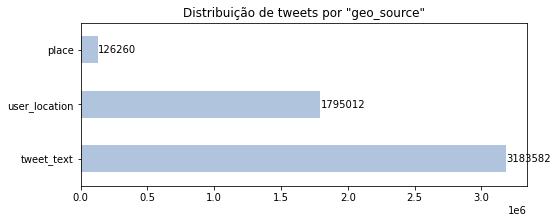

In [6]:
df_1.geo_source.value_counts().plot(kind='barh', figsize=(8, 3), title = 'Distribuição de tweets por "geo_source"', color='lightsteelblue')

for index, value in enumerate(df_1.geo_source.value_counts()):
    plt.text(value, index, str(value), verticalalignment='center')

**Investigação de registros com *geo_source* do tipo *tweet_text***

Tendo como base os quantitativos gerados acima e sabendo-se que as localizações com *geo_source* do tipo *tweet_text* possuem menor nível de confiabilidade, durante a realização deste trabalho, os registros com essa característica tiveram atenção diferenciada a fim de que pudessem ser notadas eventuais inconsistências.

Nas células a seguir são abordados casos, notados durante o andamento do trabalho, de localizações que, claramente, não correspondiam à localizações corretas ou reais.

**Primeiro caso**: Localização retirada do texto não se trata de uma local real de fato.

No exemplo a seguir, o *tweet* foi classificado pelo GeoCov19 como sendo localizado na cidade de Sério-RS. 

Na verdade, o texto faz referência à palavra "sério", mas não se trata de uma denominação de localização.

In [18]:
collection.find_one({'tweet_id': 1224037143707820032}, {'tweet_id':1,'state':1,'city':1,'lang':1, 'text': 1, 'geo_source':1,'_id': 0})

{'tweet_id': 1224037143707820032,
 'geo_source': 'tweet_text',
 'state': 'Rio Grande do Sul',
 'city': 'Sério',
 'text': 'Tratam o assunto como coisa séria mas parece que a coisa é séria mesmo.Já apareceu vídeos em que mostram psessoas em pé e de repente morrem.Sério. https://t.co/VXUmwj42QD',
 'lang': 'pt'}

No exemplo a seguir ocorre o mesmo caso do item anterior, dessa vez com a palavra "própria" que foi associada à cidade de Propriá-SE.

In [19]:
collection.find_one({'tweet_id': 1223985314122866688}, {'tweet_id':1,'state':1,'city':1,'lang':1, 'text': 1, 'geo_source':1,'_id': 0})

{'tweet_id': 1223985314122866688,
 'geo_source': 'tweet_text',
 'state': 'Sergipe',
 'city': 'Propriá',
 'text': 'Ai gente eu ficaria mto assustada pq imagina tar doente e ainda passar pra sua própria família https://t.co/Ts3McS63la',
 'lang': 'pt'}

**Segundo caso**: Localização retirada do texto se trata de um local, mas a localização considerada foi incorreta.

Neste exemplo, o texto faz referência à cidade de Rio do Sul - SC mas a localização considerada foi Rio de Janeiro-RJ.

In [20]:
collection.find_one({'tweet_id': 1224091646968635392}, {'tweet_id':1,'state':1,'city':1,'lang':1,'text': 1,'geo_source':1,'_id': 0})

{'tweet_id': 1224091646968635392,
 'geo_source': 'tweet_text',
 'state': 'Rio de Janeiro',
 'city': 'Rio de Janeiro',
 'text': 'RT @DCM_online: Surge segundo caso de Coronavirus em SC, no Rio do Sul https://t.co/mqWJxSIdHP',
 'lang': 'pt'}

Nesta outro exemplo, o conteúdo do texto sugere que o usuário encontra-se em Campos-SP, mas a palavra "Rio", identificada como a cidade de Rio de Janeiro-RJ, também é citada.

In [22]:
collection.find_one({'tweet_id': 1224078306141790211}, {'tweet_id':1,'state':1,'city':1,'lang':1,'text': 1,'geo_source':1,'_id': 0})

{'tweet_id': 1224078306141790211,
 'geo_source': 'tweet_text',
 'state': 'Rio de Janeiro',
 'city': 'Rio de Janeiro',
 'text': '@peumnzscrf Não.   é se esses malucos  trazer o coronavirus pro Rio  ?\nPRA chegar em Campos é um tiro rsrs\n\nObs: zueira 😂',
 'lang': 'pt'}

Baseados nos casos mostrados acima, foi resolvido que os ***tweets* com origem de localização *tweet_text* também seriam desconsiderados**, resultando assim na **segunda seleção** realizada na base de registros brasileiros.

A célula a seguir filtra os registros citados e totaliza novamente a quantidade de tweets selecionados.

In [6]:
df_2 = df_1.query("geo_source != 'tweet_text'")
df_2.shape[0]

1921272

#### Investigação de tweets por língua

O gráfico a seguir exibe os **idiomas mais contabilizados na base de registros**. O idioma do texto do *tweet* é informado pelo atributo *lang*, provido pelo Twitter (2) no processo de *hydrate*.

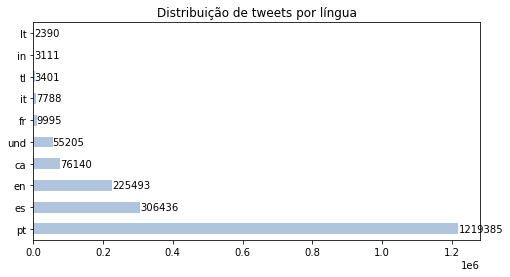

In [23]:
df_2.lang.value_counts()[:10].plot(kind='barh', figsize=(8, 4), title = 'Distribuição de tweets por língua', color='lightsteelblue')

for index, value in enumerate(df_2.lang.value_counts()[:10]):
    plt.text(value, index, str(value), verticalalignment='center')

De acordo com o gráfico acima que lista os 10 idiomas mais presentes na base de registros, além do português(pt), existem *tweets* escritos em espanhol(es), inglês(en), catalão(ca), idioma indefindo(*undefined*), francês(fr), italiano(it) e outros.

#### O caso da cidade de São Paulo-SP

Durante o andamento deste trabalho, foi notado que a cidade de São Paulo possuía demasiadamente registros em línguas diferentes do português. 

Nos passos abaixo, segue um exemplo de registros de *tweets* da cidade de São Paulo e a totalização de registros por língua.

In [23]:
df_sp = df_2.query("city == 'São Paulo'")
df_sp.head()

,geo_source,state,city,text,lang
26,user_location,São Paulo,São Paulo,RT @rimbougamra1: موقف طريف بالأمس للاعب #يوفن...,ar
36,user_location,São Paulo,São Paulo,RT @1imec: إلى الله | ♥️ .\n\nكل الناس تكلّمت ...,ar
54,user_location,São Paulo,São Paulo,RT @Elcalcio_: اكتشف أطباء في مستشفى باسكال في...,ar
193,user_location,São Paulo,São Paulo,RT @Azuri99: نشروا أطباء الايطاليين صورهم قائل...,ar
204,user_location,São Paulo,São Paulo,RT @mobeid: لمثلها نرفع القبعات احتراما\nموظفة...,ar


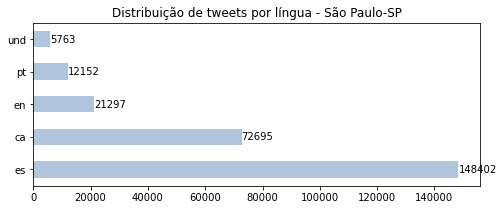

In [19]:
df_sp.lang.value_counts()[:5].plot(kind='barh', figsize=(8, 3), title = 'Distribuição de tweets por língua - São Paulo-SP', color='lightsteelblue')

for index, value in enumerate(df_sp.lang.value_counts()[:5]):
    plt.text(value, index, str(value), verticalalignment='center')

Foi observado que na cidade investigada, o português, língua nativa, era somente a 4ª língua mais utilizada (atrás até do Catalão) o que levou à desconfiança de que a maioria dos registros dessa cidade não correspondiam de fato à localizações brasileiras. 

Na célula abaixo totalizamos em porcentagem o total de registros em língua portuguesa identificados na base, o que reforça a desconfiança citada anteriormente.

In [16]:
(df_sp.query("lang == 'pt'").shape[0]/df_sp.shape[0])*100

4.615565760037678

Tendo como base o caso citado acima, optou-se por utilizar **somente *tweets* em língua portuguesa**, como uma forma de diminuir a probabilidade de considerar registros referentes à localizações não-brasileiras. 

Outro fator determinante para esta decisão foi o intuito de se utilizar funções de ***processamento de linguagem natural* em resultados de análises de sentimentos brasileiros**. Este trabalho decidiu por focar a utilização desses recursos no idioma português.

Sendo assim, é realizada a **terceira seleção** na base de registros deste trabalho, executada na célula a seguir.

In [32]:
df_3 = df_2.query("lang == 'pt'")
df_3.shape[0]

1219385

Na célula a seguir é exibido um *dataframe* com alguns registros resultantes do processo final de seleção:

In [25]:
df_3

,geo_source,state,city,text,lang
3152778,user_location,Minas Gerais,Varginha,RT @DCM_online: Ano novo chinês em São Paulo t...,pt
3152779,tweet_text,Rio Grande do Sul,Sério,As mídias amenizando o #coronavirus por causa ...,pt
3152780,tweet_text,Rio Grande do Sul,Santa Maria,RT @digital_explora: #CORONAVIRUS #CHINA/#WUHA...,pt
3152781,user_location,Ceará,Fortaleza,RT @Miltonneves: Só piora. Isso não tá parecen...,pt
3152782,user_location,São Paulo,Ribeirão Preto,RT @barbaragancia: O banana do Ernesto Araújo ...,pt
...,...,...,...,...,...
4984168,user_location,Paraná,Curitiba,@GeekAsmatica Meu coração parou por um segundo...,pt
4984169,tweet_text,São Paulo,São Paulo,"RT @Antena1Rio: Boa tarde, amigo ouvinte. Vamo...",pt
4984170,user_location,Minas Gerais,Belo Horizonte,O bombardeio é diário e ininterrupto. Praticam...,pt
4984171,user_location,Rio de Janeiro,Belford Roxo,"Vamos falar dessa nova ffc gente, chega de Cor...",pt


***
### Resumo

Este *notebook* abordou o processo de **seleção dos *tweets*** extraídos na etapa anterior. Este processo teve como finalidade **desconsiderar registros que não possuíam textos retornados pelo processo de *hydrate*** e **melhorar a probabilidade de que os registros selecionados fossem realmente de localizações brasileiras**.

Foram mostrados diversos casos em que as **localizações não eram, certamente ou possivelmente, as reais ou corretas**. Estes casos foram observados durante a manipulação dos dados no decorrer do andamento deste trabalho.

***
### Fontes

(1) GeoCoV19: A Dataset of Hundreds of Millions ofMultilingual COVID-19 Tweets with Location Information

(2) Twitter API Documentation - https://developer.twitter.com/en/docs